In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl

import pyemma as pm
import mdtraj as md
from glob import glob


from msmsense.featurizers import dihedrals, distances
# from msmsense.bootstrap_cmatrices import get_sub_dict, get_trajs
from functools import partial

In [5]:
protein = '1fme'
lag = 41
process = 2


# Hyperparameters

In [6]:
def fit_model(data,  lag, cluster_stride, tica_dim, tica_lag,  
              k, feature, distances_scheme, distances_transform, centre, steepness): 
    if feature == 'distances': 
        featurizer = partial(distances, scheme=distances_scheme,transform=distances_transform, centre=centre, steepness=steepness )
    else: 
        raise NotImplementedError()
        
    ftrajs = featurizer(data)
    
    
    tica = pm.coordinates.tica(data=ftrajs, lag=tica_lag, dim=tica_dim)
    ttrajs = tica.get_output()
    cluster = pm.coordinates.cluster_kmeans(data=ttrajs, k=k, max_iter=1000, stride=cluster_stride, fixed_seed=49587)
    dtrajs = cluster.dtrajs
    
    msm = pm.msm.estimate_markov_model(dtrajs, lag=lag, reversible=True, connectivity='largest',
                                                 mincount_connectivity="1/n")
    return (tica, cluster, msm)
    
def get_param(df,ix, param):
    result = list(df.loc[df.hp_ix == ix, :].to_dict()[param].values())[0]
    print(param, result)
    return result
    

In [7]:
summary_paths = [f'../{protein}/summary_batch1.h5', f'../{protein}/summary_batch2.h5', f'../{protein}/summary_batch3.h5']

hp_paths = ['../../experiments/hpsample.h5', '../../experiments/new_hpsample.h5', '../../experiments/new_ts_hpsample_missing_best.h5']

keep_hp_ixs = [np.array([]), np.array([329, 330, 331, 334, 335]), 
               np.array([340, 341, 342, 343, 344])]

hps = []
timescales = []

for batch_num in range(3):
    keep_ix = keep_hp_ixs[batch_num]
    
    # Hp definitions
    hp = pd.read_hdf(hp_paths[batch_num])
    hp.reset_index(inplace=True)    
    
    # Drop these columns if they exist. 
    for drop_col in ['index', 'Group']:
        if drop_col in hp.columns:
            hp.drop(labels=[drop_col], inplace=True, axis=1)
    if keep_ix.shape[0]>0: 
        hp = hp.loc[hp.hp_ix.isin(keep_ix), :]
    hps.append(hp)
    
    # timescales
    tmp = pd.read_hdf(summary_paths[batch_num], key='timescales')
    tmp.reset_index(inplace=True)
    
    # Drop these columns if they exist. 
    for drop_col in ['index', 'Group']:
        if drop_col in tmp.columns:
            tmp.drop(labels=[drop_col], inplace=True, axis=1)
    
    if keep_ix.shape[0]>0: 
        tmp = tmp.loc[tmp.hp_ix.isin(keep_ix), :]
    timescales.append(tmp)
    
       
timescales = pd.concat(timescales, axis=0)
hps = pd.concat(hps, axis=0)    

print(timescales.shape, hps.shape)

timescales = timescales.merge(hps, on=['hp_ix'], how='left')
timescales['feature'] = timescales.apply(lambda x: f"{x['feature__value']}" if x['feature__value'] =='dihedrals' else f"{x['distances__transform']}-{x['feature__value']}", axis=1)
print(timescales.shape)
timescales.drop_duplicates(inplace=True)
print(timescales.shape)

(68161, 7) (150, 14)
(68161, 21)
(68161, 21)


In [8]:
df = timescales.loc[(timescales.lag==lag) & (timescales.process==process), :].copy()

In [9]:
df.sort_values(by=['median'], ascending=False, inplace=True)

In [10]:
keep_hp_ix = [331, 24, 262]

In [11]:
df.loc[df.hp_ix.isin(keep_hp_ix)]

,hp_ix,lag,process,median,lb,ub,count,cluster__max_iter,cluster__stride,tica__dim,...,tica__kinetic_map,tica__stride,cluster__k,feature__value,dihedrals__which,distances__scheme,distances__transform,distances__steepness,distances__centre,feature
64511,331,41,2,24112.350456,3100.646541,247174.256279,100,1000,10,17,...,True,1,459,distances,NaN,ca,logistic,5.967568,0.700806,logistic-distances
54876,24,41,2,20430.946382,2322.090873,176211.392199,100,1000,10,20,...,True,1,471,distances,NaN,ca,logistic,6.081760,0.224891,logistic-distances
13291,262,41,2,9658.132641,2085.490379,188712.937937,100,1000,10,18,...,True,1,289,distances,NaN,ca,logistic,29.030558,0.798204,logistic-distances


In [12]:
traj_paths = list(glob('../../data/1fme/*.xtc'))
top_path = '../../data/1fme/protein.pdb'
data = [md.load(x, top=top_path) for x in traj_paths]

In [13]:
ix = []

In [14]:
hp_ix = keep_hp_ix[1]

lag = get_param(df, hp_ix, 'lag')
cluster_stride = get_param(df, hp_ix,  'cluster__stride')
tica_dim = get_param(df, hp_ix, 'tica__dim')
tica_lag = get_param(df, hp_ix, 'tica__lag')
k = get_param(df,  hp_ix,'cluster__k')
feature = get_param(df, hp_ix, 'feature__value')
distances_scheme = get_param(df, hp_ix, 'distances__scheme')
distances_transform = get_param(df, hp_ix, 'distances__transform')
centre = get_param(df, hp_ix, 'distances__centre')
steepness = get_param(df, hp_ix, 'distances__steepness')


# tica, cluster, msm = fit_model(data, lag, cluster_stride, tica_dim, tica_lag,  
#               k, feature, distances_scheme, distances_transform, centre, steepness)

# print(msm.timescales(2))

lag 41
cluster__stride 10
tica__dim 20
tica__lag 60
cluster__k 471
feature__value distances
distances__scheme ca
distances__transform logistic
distances__centre 0.22489078081532587
distances__steepness 6.08175994205689


getting output of TICA:   0%|                                                                                 …

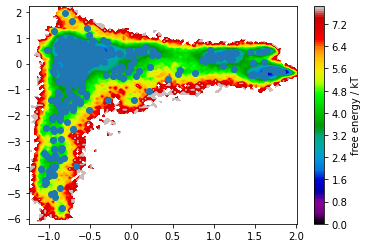

In [12]:
Y = tica.get_output()

all_Y = np.concatenate(Y)

fig, ax = plt.subplots()
pm.plots.plot_free_energy(all_Y[:, 0], all_Y[:, 1], ax=ax)
ax.scatter(cluster.clustercenters[:, 0], cluster.clustercenters[:, 1])

In [13]:
dtrajs = cluster.dtrajs

estimating MaximumLikelihoodMSM:   0%|                                                                        …

<AxesSubplot:xlabel='lag time / steps', ylabel='timescale / steps'>

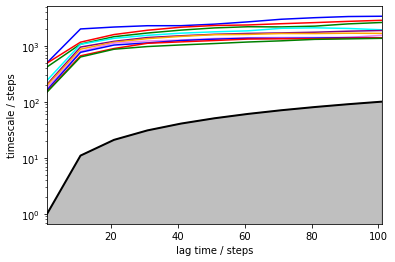

In [14]:
its = pm.msm.its(dtrajs, lags=np.arange(1, 102, 10))
pm.plots.plot_implied_timescales(its, nits=10)